In [78]:
##################################
### Import the usual libraries ###
##################################

#numpy
import numpy as np

# scipy
from scipy.stats import binned_statistic

#astropy
import astropy
from astropy.io import fits, ascii
from astropy.table import Table, Column, QTable

#matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from matplotlib.offsetbox import AnchoredText

# Yumi's Code to convert (RA,DEC) to MS coordinates
import MagellanicStream as ms

# .py files for grad calc
import astrofunctions as astro
import lmcgeometry as lgeo
import mlefitting as mle
import utilities as util

# Ignore warnings unless crashes
import warnings
warnings.filterwarnings('ignore')

#progress bars
from tqdm import tqdm_notebook

In [111]:
# LMC DR 17 data
lmc = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/lmc_rgbmembers.dr17_qacuts.fits.gz',1)
cln = np.where((lmc['FE_H']>-9999.0)&(lmc['AK_TARG']>-9999.0)&(lmc['LOGG']>0.0)&
                (lmc['M_H_ERR']>-90.0)&(lmc['C_FE']>-9999.0)&(lmc['N_FE']>-9999.0))

lmc = lmc[cln]
lmc = Table(lmc)

### ALPHA_FE
lmc['ALPHA_FE'] = lmc['ALPHA_M']+lmc['M_H']-lmc['FE_H']
lmc['ALPHA_FE_ERR'] = np.sqrt(lmc['ALPHA_M']**2+lmc['M_H']**2+lmc['FE_H']**2)

In [112]:
len(lmc)

4465

In [98]:
### Radii LMC
x,y,dist = lgeo.LMCdisk_cart(lmc['RA'],lmc['DEC'])
radius = lgeo.elliptical_radius(x,y)
     
### All elements APOGEE measures abundances for
elems = ['C_FE','N_FE','O_FE','MG_FE','AL_FE','SI_FE','CA_FE','FE_H','NI_FE','CE_FE','ALPHA_FE']
labs = ['[C/Fe]','[N/Fe]','[O/Fe]','[Mg/Fe]','[Al/Fe]','[Si/Fe]','[Ca/Fe]','[Fe/H]','[Ni/Fe]','[Ce/Fe]',
             r'[$\alpha$/Fe]']

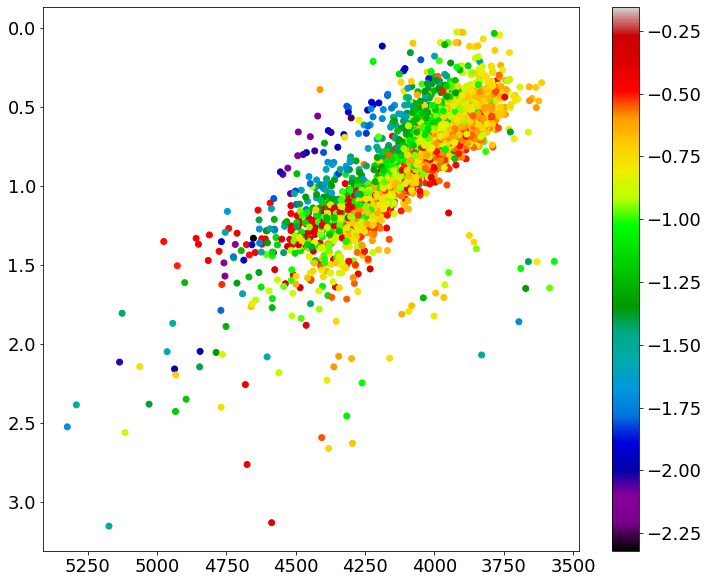

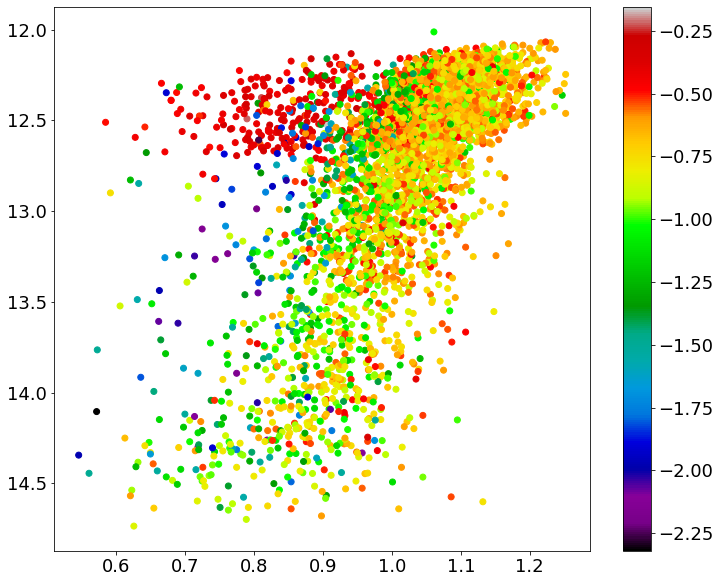

In [99]:
plt.figure(figsize=[12,10])
plt.scatter(lmc['TEFF'],lmc['LOGG'],c=lmc['FE_H'],cmap='nipy_spectral')
plt.colorbar()
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=[12,10])
plt.scatter(lmc['J']-lmc['K'],lmc['K'],c=lmc['FE_H'],cmap='nipy_spectral')
plt.colorbar()
plt.gca().invert_yaxis()
plt.show()

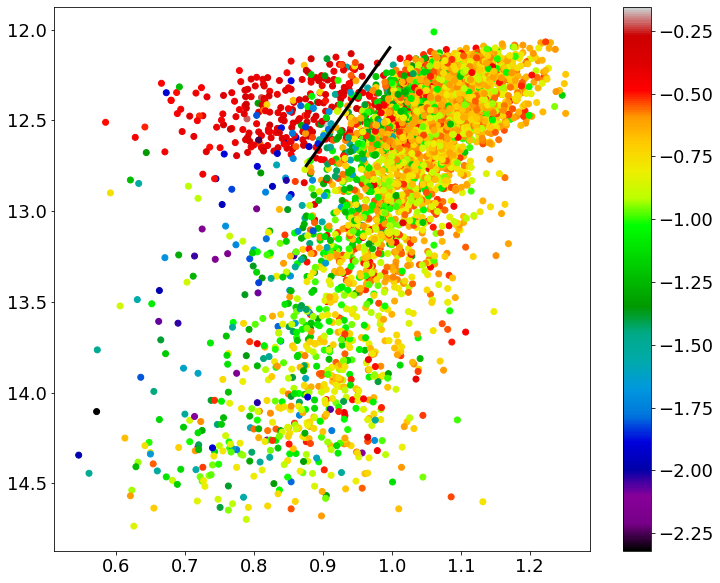

 
-5.372 x + 17.46


In [100]:
test_bloop = np.poly1d(np.polyfit([0.876,0.997],[12.75,12.1],1.))

plt.figure(figsize=[12,10])
plt.scatter(lmc['J']-lmc['K'],lmc['K'],c=lmc['FE_H'],cmap='nipy_spectral')
plt.colorbar()
plt.plot([0.876,0.997],[test_bloop(0.876),test_bloop(0.997)],c='k',lw=3.0)
plt.gca().invert_yaxis()
plt.show()

print(test_bloop)

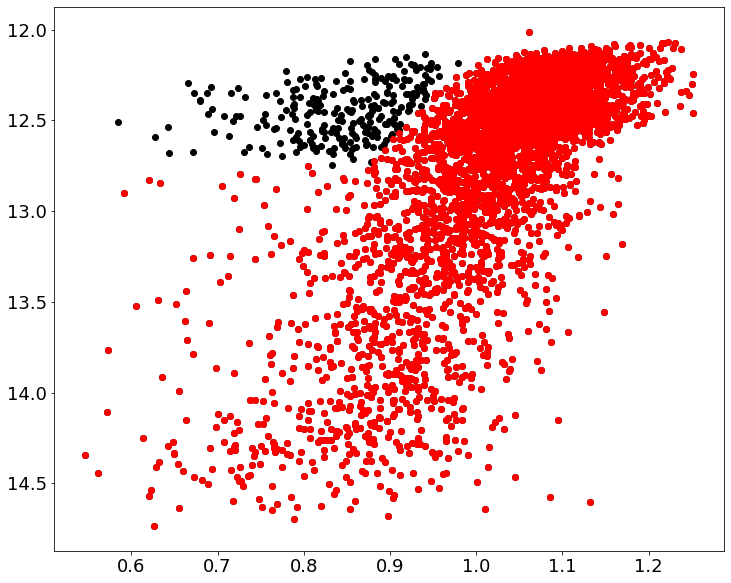

In [101]:
# bloop_cut = np.where(lmc['K']>-5.372*(lmc['J']-lmc['K'])+17.46)

def bloopjkk(color):
    '''
    Function to calculate bloop boundary in J-K K space
    
    Input:
    -----
        color: J-K color
        
    Output:
    ------
        Value of cut
    '''
    x=color
    return np.piecewise(x,[x<=0.876,x>0.876],[lambda x: 12.75, lambda x: -5.372*x+17.46])

bloop_cut = np.where(lmc['K']>bloopjkk(lmc['J']-lmc['K']))

plt.figure(figsize=[12,10])
plt.scatter(lmc['J']-lmc['K'],lmc['K'],c='k')
plt.scatter((lmc['J']-lmc['K'])[bloop_cut],lmc['K'][bloop_cut],c='r')
plt.gca().invert_yaxis()
plt.show()

In [102]:
lmc = lmc[bloop_cut]

# Initial MLE Fit

In [103]:
##############################
### Fit Overall Trendlines ###
##############################

med_ms = []
med_bs = []

### Initial fit
for i in tqdm_notebook(range(len(elems)),desc='Done?'):
    
    # clean up data
    cln = np.where((lmc[elems[i]]>-100)&(lmc['SNR']>=100))
    
    # fit data
    slope, inter = mle.mle_fit(radius[cln],lmc[elems[i]][cln],lmc[elems[i]+'_ERR'][cln])
    med_ms.append(slope)
    med_bs.append(inter)
    
# # ALPHA_FE
# alpha_fe = lmc['ALPHA_M']+lmc['M_H']-lmc['FE_H']
# alpha_fe_err = np.sqrt(lmc['ALPHA_M']**2+lmc['M_H']**2+lmc['FE_H']**2)

# cln = np.where((alpha_fe>-100)&(lmc['SNR']>=100))
# alpha_med_m, alpha_med_b = mle.mle_fit(radius[cln],alpha_fe[cln],alpha_fe_err[cln])

In [104]:
for i in range(len(med_ms)):
    print('{}: slope: {:.4f}; inter: {:.4f}'.format(elems[i],med_ms[i],med_bs[i]))
# print('ALPHA_FE: slope: {:.4f}; inter: {:.4f}'.format(alpha_med_m,alpha_med_b))

C_FE: slope: -0.0047; inter: -0.3326
N_FE: slope: 0.0005; inter: 0.0985
O_FE: slope: 0.0019; inter: 0.0459
MG_FE: slope: 0.0012; inter: 0.0508
AL_FE: slope: -0.0046; inter: -0.2966
SI_FE: slope: 0.0046; inter: -0.0220
CA_FE: slope: 0.0023; inter: 0.0569
FE_H: slope: -0.0081; inter: -0.6492
NI_FE: slope: -0.0009; inter: -0.1090
CE_FE: slope: -0.0223; inter: 0.1933
ALPHA_FE: slope: 0.0016; inter: 0.0215


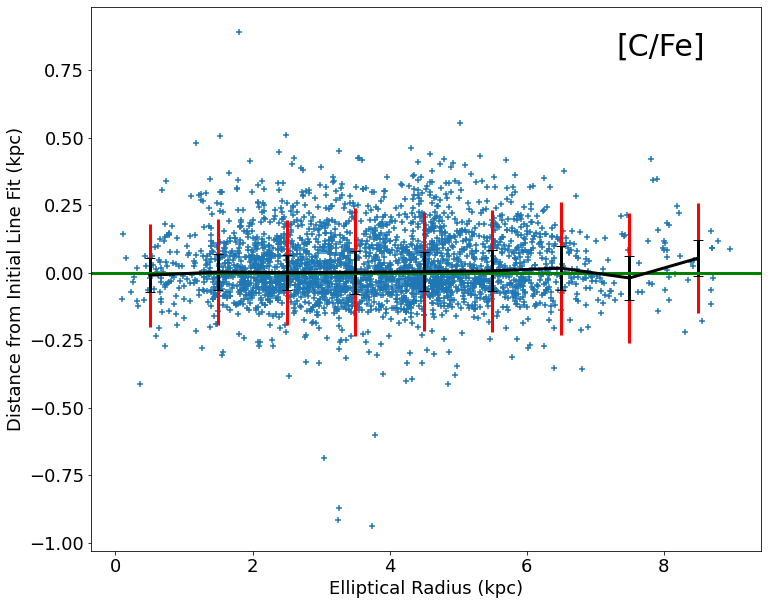

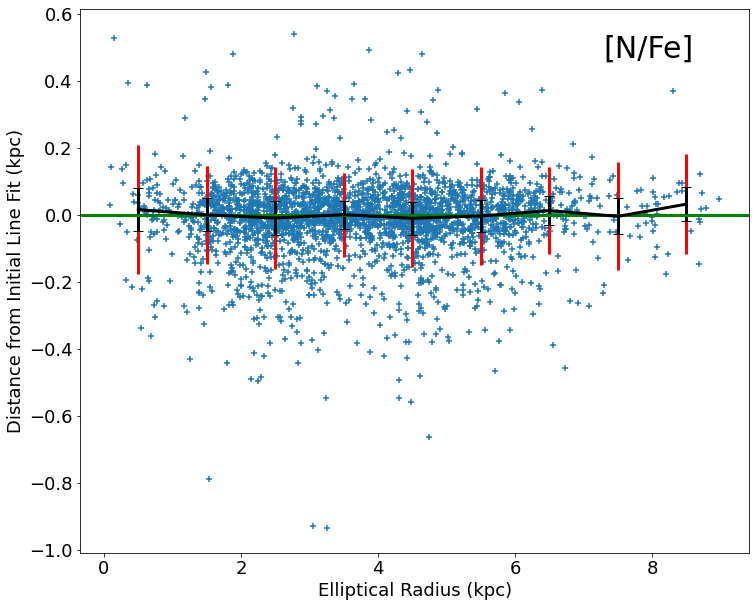

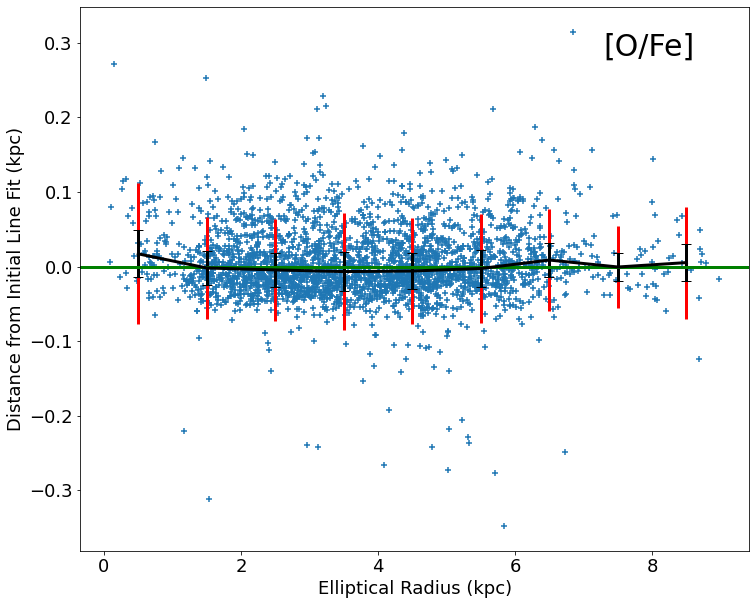

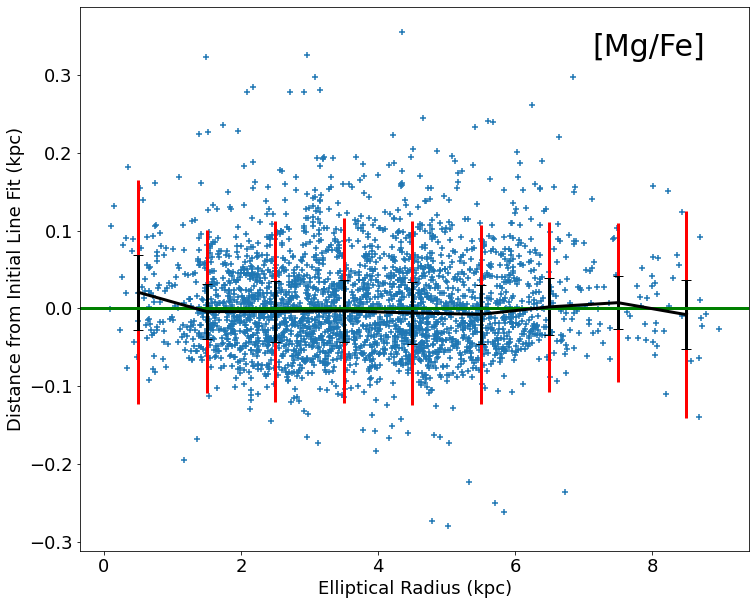

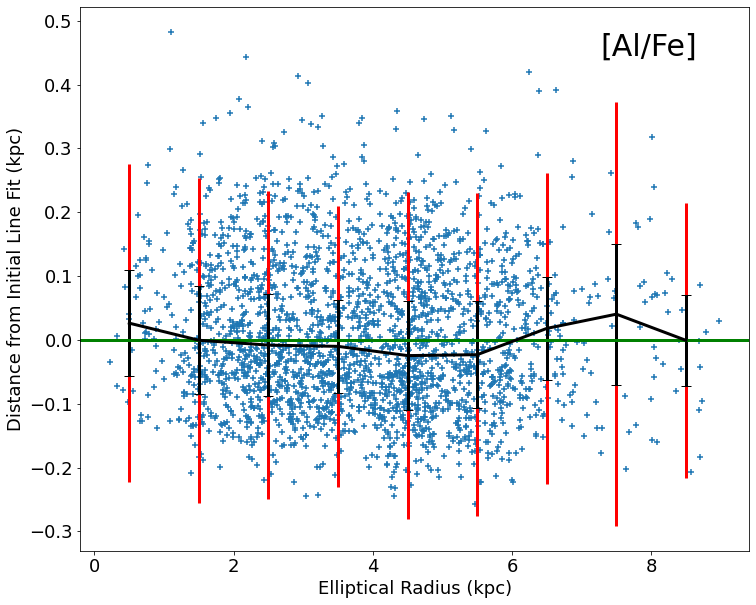

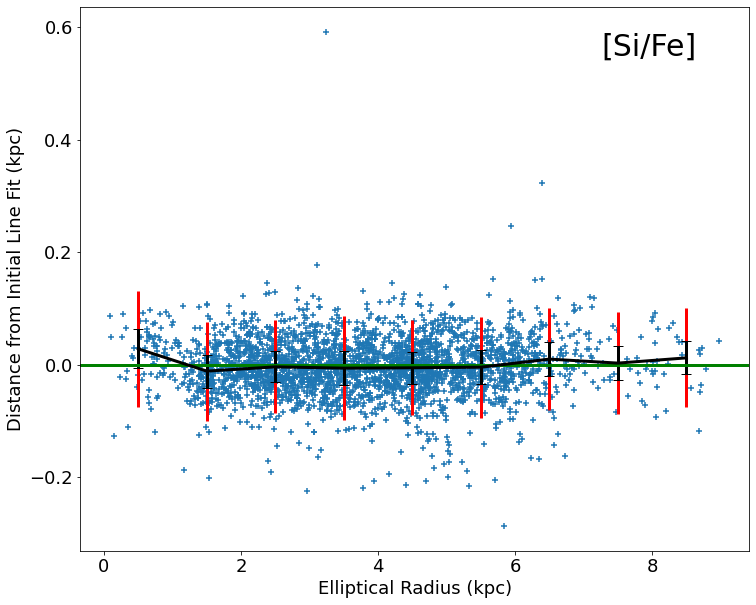

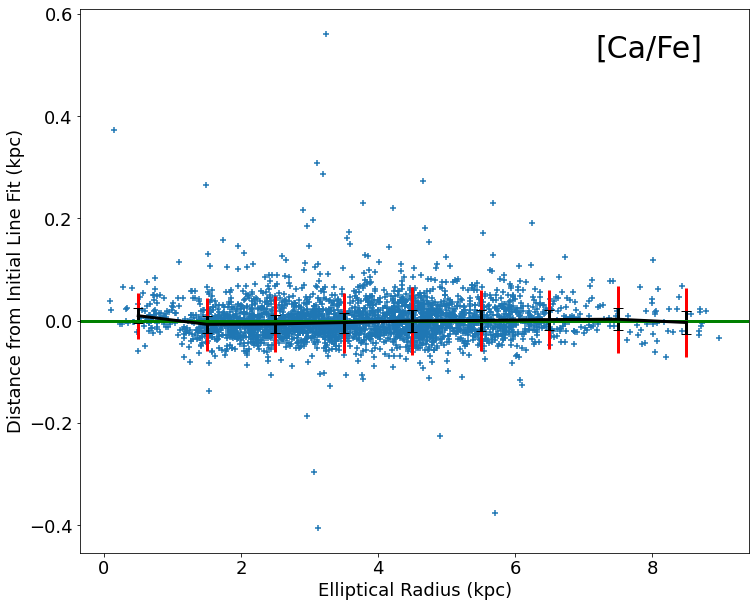

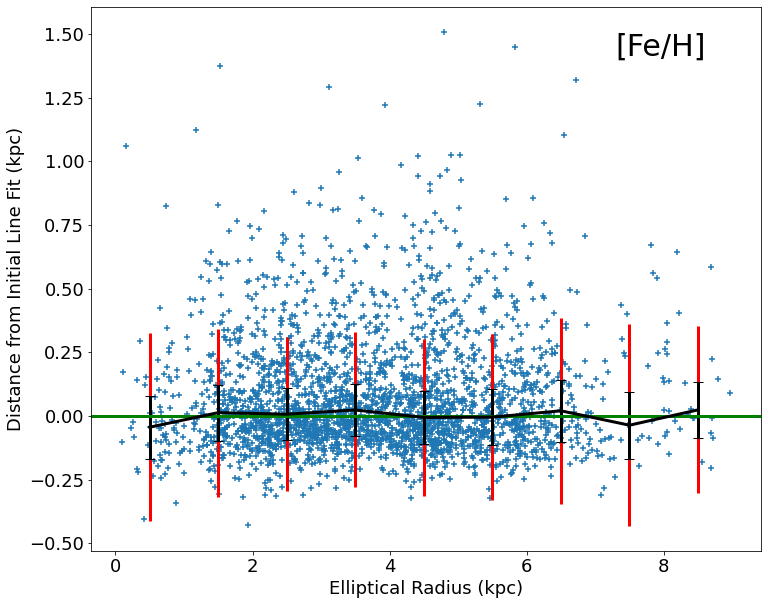

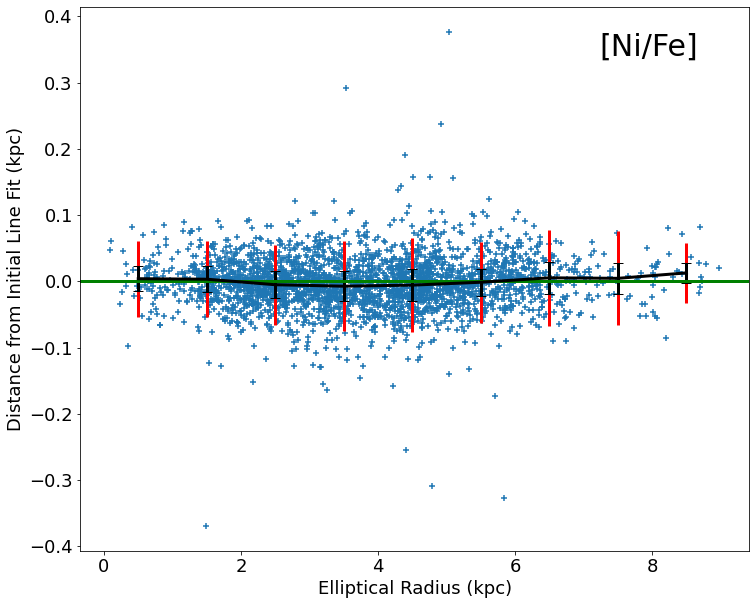

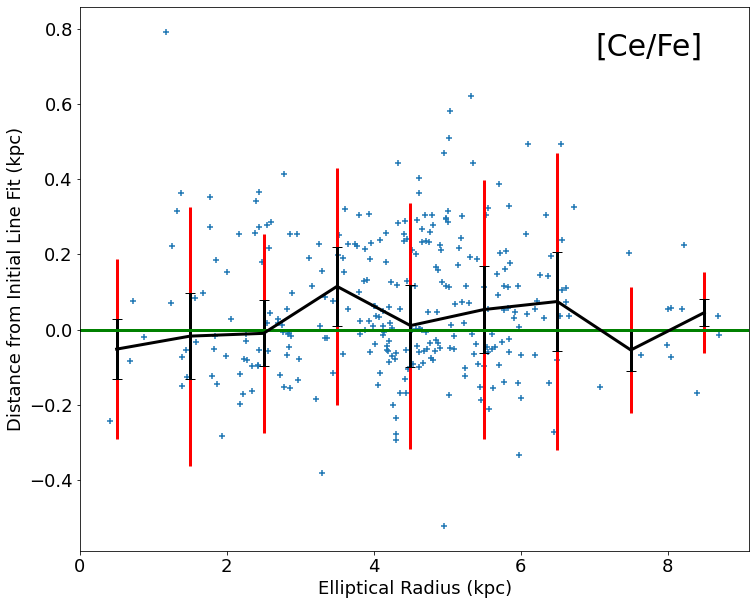

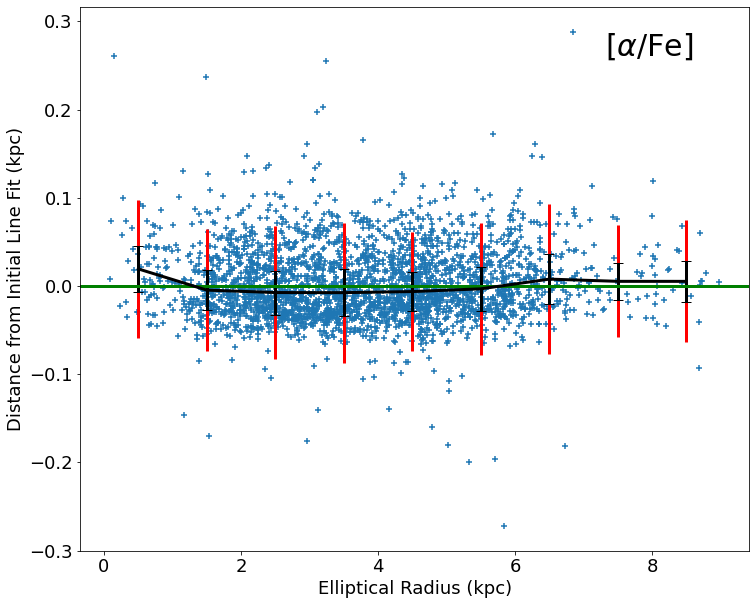

In [105]:
matplotlib.rcParams.update({'font.size': 18})
med_elems_dist = []
for i in tqdm_notebook(range(len(elems)),desc='Done?'):
    
    def trendline(x):
        return med_ms[i]*x+med_bs[i]
    
    cln = np.where((lmc[elems[i]]>-100)&(lmc['SNR']>=100))
    plug = trendline(radius[cln])
    dist = plug-lmc[elems[i]][cln]
    
    med_elems_dist.append(dist)    
    
    bins = np.append(np.arange(np.floor(np.min(radius[cln])),np.ceil(np.max(radius[cln])),1.0),
                     np.ceil(np.max(radius[cln]))+1) 
    bin_dist, _, _ = binned_statistic(radius[cln],dist,statistic='median',bins=bins)
    bin_spr, _, _ = binned_statistic(radius[cln],dist,statistic=lambda y: np.median(np.absolute(y-np.median(y))),
                                     bins=bins)
    
    plt.figure(figsize=[12,10])
    plt.scatter(radius[cln],dist,marker='+')
    plt.errorbar(bins[:-1]+0.5,bin_dist,yerr=3*bin_spr,c='r',ls='none',lw=3)
    plt.errorbar(bins[:-1]+0.5,bin_dist,yerr=bin_spr,c='k',capsize=5,lw=3)
    plt.axhline(0.0,c='g',lw=3.0)
    plt.title(r'{}'.format(labs[i]),fontsize=30,x=0.85,y=0.90)#,len(np.squeeze(cln))))
    plt.xlabel(r'Elliptical Radius (kpc)')
    plt.ylabel(r'Distance from Initial Line Fit (kpc)')
#     plt.savefig('outliers{}'.format(elems[i]),bbox_inches='tight')
    plt.show()

In [106]:
med_m_devs = []
med_b_devs = []
re_med_ms = []
re_med_bs = []

prune_fact = 3.
for i in tqdm_notebook(range(len(elems)),desc='Done?'):
    
    # clean up data and prune outliers
    cln = np.where((lmc[elems[i]]>-100)&(lmc['SNR']>=100))
    prune = np.where((lmc[elems[i]]>-prune_fact*util.mad(med_elems_dist[i])+
                      np.median(lmc[cln][elems[i]]))&
                     (lmc[elems[i]]<prune_fact*util.mad(med_elems_dist[i])+
                      np.median(lmc[cln][elems[i]])))

    exog = radius[prune]
    endog = lmc[elems[i]][prune]
    endog_err = lmc[elems[i]+'_ERR'][prune]
    
    slps = []
    ints = []
    
    # resample with replacement 100 times and fit lines
    for j in tqdm_notebook(range(1000),leave=False,desc='Iteration'):
        
        ind = np.floor(np.random.random(len(endog))*(len(endog)-1)).astype(int)
        indexog = exog[ind]
        indendog = endog[ind]
        indendog_err = endog_err[ind]
        
        # fit sampled data
        try:
            sample_slope, sample_inter = mle.mle_fit(indexog,indendog,indendog_err)
            slps.append(sample_slope)
            ints.append(sample_inter)
        
        except:
            slps.append(-9999.0)
            ints.append(-9999.0)
        
    med_m_devs.append(util.mad(slps))
    med_b_devs.append(util.mad(ints))
    
    re_med_ms.append(np.median(slps))
    re_med_bs.append(np.median(ints))

In [107]:
for i in range(len(re_med_ms)):
    print('{}: slope: {:.4f} +/- {:.4f} inter: {:.4f} +/- {:.4f}'.format(labs[i],re_med_ms[i],med_m_devs[i],
                                                                         re_med_bs[i],med_b_devs[i]))

[C/Fe]: slope: -0.0047 +/- 0.0021 inter: -0.3321 +/- 0.0063
[N/Fe]: slope: 0.0014 +/- 0.0011 inter: 0.0887 +/- 0.0037
[O/Fe]: slope: 0.0013 +/- 0.0005 inter: 0.0533 +/- 0.0021
[Mg/Fe]: slope: 0.0011 +/- 0.0007 inter: 0.0518 +/- 0.0027
[Al/Fe]: slope: -0.0052 +/- 0.0024 inter: -0.2940 +/- 0.0079
[Si/Fe]: slope: 0.0037 +/- 0.0006 inter: -0.0138 +/- 0.0024
[Ca/Fe]: slope: 0.0017 +/- 0.0006 inter: 0.0611 +/- 0.0017
[Fe/H]: slope: -0.0025 +/- 0.0030 inter: -0.6495 +/- 0.0093
[Ni/Fe]: slope: -0.0017 +/- 0.0005 inter: -0.1051 +/- 0.0018
[Ce/Fe]: slope: -0.0458 +/- 0.0384 inter: 0.2105 +/- 0.0508
[$\alpha$/Fe]: slope: 0.0008 +/- 0.0006 inter: 0.0287 +/- 0.0019


In [110]:
# len(ages)
len(lmc)

4210

In [109]:
# Ages
ages = fits.getdata('/Users/joshuapovick/Desktop/Research/LMC_Ages/Polynomial_LMC_Ages/TEST_pca_ols_agesDR17.fits')

#####################
### Make Age Bins ###
#####################

young = np.where((ages['AGE']>0.0)&(ages['AGE']<=np.log10(0.5*10**9)))
yless = np.where((ages['AGE']>np.log10(0.5*10**9))&(ages['AGE']<=np.log10(2.0*10**9)))
ymed = np.where((ages['AGE']>np.log10(2.0*10**9))&(ages['AGE']<=np.log10(7*10**9)))
omed = np.where((ages['AGE']>np.log10(7*10**9))&(ages['AGE']<=np.log10(10.5*10**9)))
old = np.where(ages['AGE']>np.log10(10.5*10**9))

lmcyoung = lmc[young]
lmcyless = lmc[yless]
lmcymed = lmc[ymed]
lmcomed = lmc[omed]
lmcold = lmc[old]

IndexError: index 4247 is out of bounds for axis 0 with size 4210

In [ ]:
print(len(lmcyoung))
print(len(lmcyless))
print(len(lmcymed))
print(len(lmcomed))
print(len(lmcold))

In [ ]:
##################################
### Age bin initial Trendlines ###
##################################

### young

young_ms = []
young_bs = []

lmcyoung = lmc[young]

### Initial fit
for i in tqdm_notebook(range(len(elems)),desc='Done?'):
    
    # clean up data
    cln = np.where((lmcyoung[elems[i]]>-100))
    
    try:
        # fit data
        slope, inter = mle.mle_fit(radius[young][cln],lmcyoung[elems[i]][cln],lmcyoung[elems_err[i]][cln])
        young_ms.append(slope)
        young_bs.append(inter)
        
    except:
        young_ms.append(-9999.0)
        young_bs.append(-9999.0)
    
### yless

yless_ms = []
yless_bs = []

lmcyless = lmc[yless]

### Initial fit
for i in tqdm_notebook(range(len(elems)),desc='Done?'):
    
    # clean up data
    cln = np.where((lmcyless[elems[i]]>-100))
    
    try:
        # fit data
        slope, inter = mle.mle_fit(radius[yless][cln],lmcyless[elems[i]][cln],lmcyless[elems_err[i]][cln])
        yless_ms.append(slope)
        yless_bs.append(inter)
        
    except:
        yless_ms.append(-9999.0)
        yless_bs.append(-9999.0)
    
### ymed

ymed_ms = []
ymed_bs = []

lmcymed = lmc[ymed]

### Initial fit
for i in tqdm_notebook(range(len(elems)),desc='Done?'):
    
    # clean up data
    cln = np.where((lmcymed[elems[i]]>-100))
    
    try:
        # fit data
        slope, inter = mle.mle_fit(radius[ymed][cln],lmcymed[elems[i]][cln],lmcymed[elems_err[i]][cln])
        ymed_ms.append(slope)
        ymed_bs.append(inter)
        
    except:
        ymed_ms.append(-9999.0)
        ymed_bs.append(-9999.0)
    
### omed

omed_ms = []
omed_bs = []

lmcomed = lmc[omed]

### Initial fit
for i in tqdm_notebook(range(len(elems)),desc='Done?'):
    
    # clean up data
    cln = np.where((lmcomed[elems[i]]>-100))
    
    try:
        # fit data
        slope, inter = mle.mle_fit(radius[omed][cln],lmcomed[elems[i]][cln],lmcomed[elems_err[i]][cln])
        omed_ms.append(slope)
        omed_bs.append(inter)
        
    except:
        omed_ms.append(-9999.0)
        omed_bs.append(-9999.0)
    
### old

old_ms = []
old_bs = []

lmcold = lmc[old]

### Initial fit
for i in tqdm_notebook(range(len(elems)),desc='Done?'):
    
    # clean up data
    cln = np.where((lmcold[elems[i]]>-100))
    
    try:
        # fit data
        slope, inter = mle.mle_fit(radius[old][cln],lmcold[elems[i]][cln],lmcold[elems_err[i]][cln])
        old_ms.append(slope)
        old_bs.append(inter)
        
    except:
        old_ms.append(-9999.0)
        old_bs.append(-9999.0)

In [ ]:
############################################
### Find distances between data and fits ###
############################################

young_dist = []
for i in tqdm_notebook(range(len(elems)),desc='Done?'):
    
    def trendline(x):
        return young_ms[i]*x+young_bs[i]
    
    cln = np.where((lmcyoung[elems[i]]>-100))
    plug = trendline(radius[young][cln])
    dist = plug-lmcyoung[elems[i]][cln]
    
    young_dist.append(dist) 
    
yless_dist = []
for i in tqdm_notebook(range(len(elems)),desc='Done?'):
    
    def trendline(x):
        return yless_ms[i]*x+yless_bs[i]
    
    cln = np.where((lmcyless[elems[i]]>-100))
    plug = trendline(radius[yless][cln])
    dist = plug-lmcyless[elems[i]][cln]
    
    yless_dist.append(dist) 
    
ymed_dist = []
for i in tqdm_notebook(range(len(elems)),desc='Done?'):
    
    def trendline(x):
        return ymed_ms[i]*x+ymed_bs[i]
    
    cln = np.where((lmcymed[elems[i]]>-100))
    plug = trendline(radius[ymed][cln])
    dist = plug-lmcymed[elems[i]][cln]
    
    ymed_dist.append(dist) 
    
omed_dist = []
for i in tqdm_notebook(range(len(elems)),desc='Done?'):
    
    def trendline(x):
        return omed_ms[i]*x+omed_bs[i]
    
    cln = np.where((lmcomed[elems[i]]>-100))
    plug = trendline(radius[omed][cln])
    dist = plug-lmcomed[elems[i]][cln]
    
    omed_dist.append(dist) 
    
old_dist = []
for i in tqdm_notebook(range(len(elems)),desc='Done?'):
    
    def trendline(x):
        return old_ms[i]*x+old_bs[i]
    
    cln = np.where((lmcold[elems[i]]>-100))
    plug = trendline(radius[old][cln])
    dist = plug-lmcold[elems[i]][cln]
    
    old_dist.append(dist)

In [ ]:
###################
### Prune Refit ###
###################

prune_fact = 3.0

re_young_ms = []
re_young_bs = []
young_m_devs = []
young_b_devs = []

for i in tqdm_notebook(range(len(elems)),desc='Done?'):
    
    # clean up data and prune outliers
    cln = np.where((lmcyoung[elems[i]]>-100))
    prune = np.where((lmcyoung[elems[i]]>-prune_fact*util.mad(young_dist[i])+
                      np.median(lmcyoung[cln][elems[i]]))&
                     (lmcyoung[elems[i]]<prune_fact*util.mad(young_dist[i])+
                      np.median(lmcyoung[cln][elems[i]])))

    exog = radius[young][prune]
    endog = lmcyoung[elems[i]][prune]
    endog_err = lmcyoung[elems[i]+'_ERR'][prune]
    
    slps = []
    ints = []
    
    # resample with replacement 100 times and fit lines
    for j in tqdm_notebook(range(1000),leave=False,desc='Iteration'):
        
        ind = np.floor(np.random.random(len(endog))*(len(endog)-1)).astype(int)
        indexog = exog[ind]
        indendog = endog[ind]
        indendog_err = endog_err[ind]
        
        # fit sampled data
        try:
            sample_slope, sample_inter = mle.mle_fit(indexog,indendog,indendog_err)
            slps.append(sample_slope)
            ints.append(sample_inter)
        
        except:
            slps.append(-9999.0)
            ints.append(-9999.0)
        
    young_m_devs.append(util.mad(slps))
    young_b_devs.append(util.mad(ints))
    re_young_ms.append(np.median(slps))
    re_young_bs.append(np.median(ints))

re_yless_ms = []
re_yless_bs = []
yless_m_devs = []
yless_b_devs = []

for i in tqdm_notebook(range(len(elems)),desc='Done?'):
    
    # clean up data and prune outliers
    cln = np.where((lmcyless[elems[i]]>-100))
    prune = np.where((lmcyless[elems[i]]>-prune_fact*util.mad(yless_dist[i])+
                      np.median(lmcyless[cln][elems[i]]))&
                     (lmcyless[elems[i]]<prune_fact*util.mad(yless_dist[i])+
                      np.median(lmcyless[cln][elems[i]])))

    exog = radius[yless][prune]
    endog = lmcyless[elems[i]][prune]
    endog_err = lmcyless[elems[i]+'_ERR'][prune]
    
    slps = []
    ints = []
    
    # resample with replacement 100 times and fit lines
    for j in tqdm_notebook(range(1000),leave=False,desc='Iteration'):
        
        ind = np.floor(np.random.random(len(endog))*(len(endog)-1)).astype(int)
        indexog = exog[ind]
        indendog = endog[ind]
        indendog_err = endog_err[ind]
        
        # fit sampled data
        try:
            sample_slope, sample_inter = mle.mle_fit(indexog,indendog,indendog_err)
            slps.append(sample_slope)
            ints.append(sample_inter)
        
        except:
            slps.append(-9999.0)
            ints.append(-9999.0)
        
    yless_m_devs.append(util.mad(slps))
    yless_b_devs.append(util.mad(ints))
    re_yless_ms.append(np.median(slps))
    re_yless_bs.append(np.median(ints))

re_ymed_ms = []
re_ymed_bs = []
ymed_m_devs = []
ymed_b_devs = []

for i in tqdm_notebook(range(len(elems)),desc='Done?'):
    
    # clean up data and prune outliers
    cln = np.where((lmcymed[elems[i]]>-100))
    prune = np.where((lmcymed[elems[i]]>-prune_fact*util.mad(ymed_dist[i])+
                      np.median(lmcymed[cln][elems[i]]))&
                     (lmcymed[elems[i]]<prune_fact*util.mad(ymed_dist[i])+
                      np.median(lmcymed[cln][elems[i]])))

    exog = radius[ymed][prune]
    endog = lmcymed[elems[i]][prune]
    endog_err = lmcymed[elems[i]+'_ERR'][prune]
    
    slps = []
    ints = []
    
    # resample with replacement 100 times and fit lines
    for j in tqdm_notebook(range(1000),leave=False,desc='Iteration'):
        
        ind = np.floor(np.random.random(len(endog))*(len(endog)-1)).astype(int)
        indexog = exog[ind]
        indendog = endog[ind]
        indendog_err = endog_err[ind]
        
        # fit sampled data
        try:
            sample_slope, sample_inter = mle.mle_fit(indexog,indendog,indendog_err)
            slps.append(sample_slope)
            ints.append(sample_inter)
        
        except:
            slps.append(-9999.0)
            ints.append(-9999.0)
        
    ymed_m_devs.append(util.mad(slps))
    ymed_b_devs.append(util.mad(ints))
    re_ymed_ms.append(np.median(slps))
    re_ymed_bs.append(np.median(ints))

re_omed_ms = []
re_omed_bs = []
omed_m_devs = []
omed_b_devs = []

for i in tqdm_notebook(range(len(elems)),desc='Done?'):
    
    # clean up data and prune outliers
    cln = np.where((lmcomed[elems[i]]>-100))
    prune = np.where((lmcomed[elems[i]]>-prune_fact*util.mad(omed_dist[i])+
                      np.median(lmcomed[cln][elems[i]]))&
                     (lmcomed[elems[i]]<prune_fact*util.mad(omed_dist[i])+
                      np.median(lmcomed[cln][elems[i]])))

    exog = radius[omed][prune]
    endog = lmcomed[elems[i]][prune]
    endog_err = lmcomed[elems[i]+'_ERR'][prune]
    
    slps = []
    ints = []
    
    # resample with replacement 100 times and fit lines
    for j in tqdm_notebook(range(1000),leave=False,desc='Iteration'):
        
        ind = np.floor(np.random.random(len(endog))*(len(endog)-1)).astype(int)
        indexog = exog[ind]
        indendog = endog[ind]
        indendog_err = endog_err[ind]
        
        # fit sampled data
        try:
            sample_slope, sample_inter = mle.mle_fit(indexog,indendog,indendog_err)
            slps.append(sample_slope)
            ints.append(sample_inter)
        
        except:
            slps.append(-9999.0)
            ints.append(-9999.0)
        
    omed_m_devs.append(util.mad(slps))
    omed_b_devs.append(util.mad(ints))
    re_omed_ms.append(np.median(slps))
    re_omed_bs.append(np.median(ints))
    
re_old_ms = []
re_old_bs = []
old_m_devs = []
old_b_devs = []

for i in tqdm_notebook(range(len(elems)),desc='Done?'):
    
    # clean up data and prune outliers
    cln = np.where((lmcold[elems[i]]>-100))
    prune = np.where((lmcold[elems[i]]>-prune_fact*util.mad(old_dist[i])+
                      np.median(lmcold[cln][elems[i]]))&
                     (lmcold[elems[i]]<prune_fact*util.mad(old_dist[i])+
                      np.median(lmcold[cln][elems[i]])))

    exog = radius[old][prune]
    endog = lmcold[elems[i]][prune]
    endog_err = lmcold[elems[i]+'_ERR'][prune]
    
    slps = []
    ints = []
    
    # resample with replacement 100 times and fit lines
    for j in tqdm_notebook(range(1000),leave=False,desc='Iteration'):
        
        ind = np.floor(np.random.random(len(endog))*(len(endog)-1)).astype(int)
        indexog = exog[ind]
        indendog = endog[ind]
        indendog_err = endog_err[ind]
        
        # fit sampled data
        try:
            sample_slope, sample_inter = mle.mle_fit(indexog,indendog,indendog_err)
            slps.append(sample_slope)
            ints.append(sample_inter)
        
        except:
            slps.append(-9999.0)
            ints.append(-9999.0)
        
    old_m_devs.append(util.mad(slps))
    old_b_devs.append(util.mad(ints))
    re_old_ms.append(np.median(slps))
    re_old_bs.append(np.median(ints))

In [ ]:
####################
### Summary plot ###
####################


idx = [np.squeeze(np.where(np.asarray(elems)=='FE_H')),np.squeeze(np.where(np.asarray(elems)=='C_FE')),
       np.squeeze(np.where(np.asarray(elems)=='N_FE')),np.squeeze(np.where(np.asarray(elems)=='O_FE')),
       np.squeeze(np.where(np.asarray(elems)=='MG_FE')),np.squeeze(np.where(np.asarray(elems)=='SI_FE')),
       np.squeeze(np.where(np.asarray(elems)=='CA_FE')),np.squeeze(np.where(np.asarray(elems)=='AL_FE')),
       np.squeeze(np.where(np.asarray(elems)=='NI_FE')),np.squeeze(np.where(np.asarray(elems)=='CE_FE'))]#,
       #np.squeeze(np.where(np.asarray(elems)=='V_FE'))]

good_young = []
good_yless = []
good_ymed = []
good_omed = []
good_old = []
good_over = []

err_young = []
err_yless = []
err_ymed = []
err_omed = []
err_old = []
err_over = []

for i in idx:
    good_young.append(re_young_ms[i])
    good_yless.append(re_yless_ms[i])
    good_ymed.append(re_ymed_ms[i])
    good_omed.append(re_omed_ms[i])
    good_old.append(re_old_ms[i])
    good_over.append(re_med_ms[i])
    
    err_young.append(young_m_devs[i])
    err_yless.append(yless_m_devs[i])
    err_ymed.append(ymed_m_devs[i])
    err_omed.append(omed_m_devs[i])
    err_old.append(old_m_devs[i])
    err_over.append(med_m_devs[i])

matplotlib.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=[20,10])

plt.scatter(np.add(np.arange(10),0.25),good_young,c='purple',label='$0.0 < \\tau \leq 0.5$ Gyr',s=50)
plt.errorbar(np.add(np.arange(10),0.25),good_young,yerr=err_young,c='purple',ls='none')

plt.scatter(np.add(np.arange(10),0.125),good_yless,c='blue',label='$0.5 < \\tau \leq 2.0$ Gyr',s=50)
plt.errorbar(np.add(np.arange(10),0.125),good_yless,yerr=err_yless,c='blue',ls='none')

plt.scatter([0,1,2,3,4,5,6,7,8,9],good_ymed,c='green',label='$2.0 < \\tau \leq 7.0$ Gyr',s=50)
plt.errorbar([0,1,2,3,4,5,6,7,8,9],good_ymed,yerr=err_ymed,c='green',ls='none')

plt.scatter(np.subtract(np.arange(10),0.125),good_omed,c='orange',label='$7.0 < \\tau \leq 10.5$ Gyr',s=50)
plt.errorbar(np.subtract(np.arange(10),0.125),good_omed,yerr=err_omed,c='orange',ls='none')

plt.scatter(np.subtract(np.arange(10),0.25),good_old,c='red',label='$10.5 < \\tau $ Gyr',s=50)
plt.errorbar(np.subtract(np.arange(10),0.25),good_old,yerr=err_old,c='red',ls='none')

plt.scatter([0,1,2,3,4,5,6,7,8,9],good_over,marker='*',c='black',label='Overall',s=200)
plt.errorbar([0,1,2,3,4,5,6,7,8,9],good_over,yerr=err_over,c='black',ls='none')

xplotlab = ['[Fe/H]','[C/Fe]','[N/Fe]','[O/Fe]','[Mg/Fe]','[Si/Fe]','[Ca/Fe]','[Al/Fe]','[Ni/Fe]',
            '[Ce/Fe]']#,'[V/Fe]']

xplotpos = [0,1,2,3,4,5,6,7,8,9]#,10] 
plt.xticks(xplotpos,xplotlab)

# plt.axvline(0.5,c='k',ls='--')
# plt.axvline(4.5,c='k',ls='--')
# plt.axvline(6.5,c='k',ls='--')
# plt.axhline(0.0,c='slategrey',ls='-')
plt.ylabel('Abundance Gradient Value $\,(dex/kpc)$',fontsize=30)

# plt.gca().set_ylim(top=0.05)

# plt.text(-0.375,0.0435,'Iron',fontsize=30)
# plt.text(1.75,0.0435,'$\\alpha$ Elements',fontsize=30)
# plt.text(5.0,0.0435,'Odd Z',fontsize=30)
# plt.text(7.4,0.0435,'Iron Peak',fontsize=30)

# plt.ylim(bottom=-0.045)
# plt.ylim(-0.05,0.05)

plt.legend(loc=(0.205,0.01),frameon=True,fancybox=False,fontsize='large')
plt.tight_layout()
# plt.savefig('gradientSummaryplot.png',bbox_inches='tight')
plt.show()

In [72]:
i=0
cln = np.where((lmcold[elems[i]]>-100))
prune = np.where((lmcold[elems[i]]>-prune_fact*util.mad(old_dist[i])+
                      np.median(lmcold[cln][elems[i]]))&
                     (lmcold[elems[i]]<prune_fact*util.mad(old_dist[i])+
                      np.median(lmcold[cln][elems[i]])))

exog = radius[old][prune]
endog = lmcold[elems[i]][prune]
endog_err = lmcold[elems[i]+'_ERR'][prune]

endog

-0.14181
-0.70487976
-0.058923006
-0.9320401
-0.45603
-0.63876
-0.07013202
-0.8541199
-0.65946996
-0.94273007
-0.0023195148


In [75]:
re_omed_ms

[nan,
 0.029930055141448975,
 nan,
 nan,
 -0.014624738214155584,
 nan,
 nan,
 nan,
 nan,
 -0.00010226407105705946,
 nan]

In [44]:
elems

['C_FE',
 'N_FE',
 'O_FE',
 'MG_FE',
 'AL_FE',
 'SI_FE',
 'CA_FE',
 'FE_H',
 'NI_FE',
 'CE_FE',
 'ALPHA_FE']

In [45]:
[np.squeeze(np.where(np.asarray(elems)=='FE_H')),np.squeeze(np.where(np.asarray(elems)=='C_FE')),
       np.squeeze(np.where(np.asarray(elems)=='N_FE')),np.squeeze(np.where(np.asarray(elems)=='O_FE')),
       np.squeeze(np.where(np.asarray(elems)=='MG_FE')),np.squeeze(np.where(np.asarray(elems)=='SI_FE')),
       np.squeeze(np.where(np.asarray(elems)=='CA_FE')),np.squeeze(np.where(np.asarray(elems)=='AL_FE')),
       np.squeeze(np.where(np.asarray(elems)=='NI_FE')),np.squeeze(np.where(np.asarray(elems)=='CE_FE'))]

[array(7),
 array(0),
 array(1),
 array(2),
 array(3),
 array(5),
 array(6),
 array(4),
 array(8),
 array(9)]

In [76]:
good_omed

[nan,
 nan,
 0.029930055141448975,
 nan,
 nan,
 nan,
 nan,
 -0.014624738214155584,
 nan,
 -0.00010226407105705946]